In [1]:
import sys
# Before using tensorflow:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
import tensorflow.keras.backend as KB
from matplotlib import pylab as plt
import tensorflow.keras
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

import pickle
import numpy as np
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


Tensor Flow Version: 2.4.1
Keras Version: 2.4.0

Python 3.8.5 (default, May 27 2021, 13:30:53) 
[GCC 9.3.0]
GPU is available


## Create model

In [2]:
import tensorflow
from client.models.AMLmodel import AMLModel, construct_model

#model = AMLModel()
model = construct_model()

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        1184      
_________________________________________________________________
activation (Activation)      (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        1

## Load training data

In [13]:
import numpy as np
from client.data.datagenerator import DataGenerator
labels = np.load('dataset/processed/data_partitions/partition0/labels.npy', allow_pickle=True).item()

data_path = 'dataset/processed/data_partitions/partition0/data_singlets'

ids = [l for l in labels]
np.random.shuffle(ids)
train_split_index = int(len(ids)*0.9)
train_ids = ids[:train_split_index]
val_ids = ids[train_split_index:]

train_gen = DataGenerator(train_ids,labels, data_path, dim=(100,100), batch_size=32)
val_gen = DataGenerator(val_ids,labels, data_path, dim=(100,100), batch_size=32)

## Train model
Replace the trained model with some global model trained federated in fedn

In [5]:
model.fit(train_gen, validation_data=val_gen, epochs=10)
model_json = model.to_json()
f = open('model.json', 'w')
f.write(model_json)
f.close()
model.save_weights('model_weights.h5')

Epoch 1/10
51/51 [==============================] - 14s 21ms/step - loss: 1.9416 - accuracy: 0.5136 - val_loss: 3.8350 - val_accuracy: 0.4125
Epoch 2/10
51/51 [==============================] - 1s 13ms/step - loss: 0.7537 - accuracy: 0.7653 - val_loss: 1.4827 - val_accuracy: 0.6000
Epoch 3/10
51/51 [==============================] - 1s 13ms/step - loss: 0.5440 - accuracy: 0.8135 - val_loss: 2.5130 - val_accuracy: 0.2625
Epoch 4/10
51/51 [==============================] - 1s 14ms/step - loss: 0.4538 - accuracy: 0.8397 - val_loss: 0.8345 - val_accuracy: 0.7750
Epoch 5/10
51/51 [==============================] - 1s 14ms/step - loss: 0.2984 - accuracy: 0.8941 - val_loss: 0.8359 - val_accuracy: 0.7875
Epoch 6/10
51/51 [==============================] - 1s 14ms/step - loss: 0.2722 - accuracy: 0.8996 - val_loss: 1.1624 - val_accuracy: 0.7000
Epoch 7/10
51/51 [==============================] - 1s 14ms/step - loss: 0.1885 - accuracy: 0.9269 - val_loss: 0.9871 - val_accuracy: 0.7750
Epoch 8/10
5

In [ ]:
model = tensorflow.keras.models.load_model('MLmodel.hdf5')

# Results
We are using partition1 as testset to evaluate the model.

In [16]:
labels = np.load('dataset/processed/data_partitions/partition1/labels.npy', allow_pickle=True).item()

data_path = 'dataset/processed/data_partitions/partition1/data_singlets'

ids = [l for l in labels]
np.random.shuffle(ids)

test_gen = DataGenerator(ids,labels, data_path, dim=(100,100), batch_size=32)

labels, preds = test_gen.predict_all(model)

In [7]:
def confusion_matrix(model, data_gen):
    
    labels, preds = data_gen.predict_all(model)

    y_pred = np.argmax(preds,1)
    y_data = np.argmax(labels,1)
    M = np.zeros((16,16))

    for pred_, true_ in zip(y_pred,y_data):
        M[true_,pred_] +=1
    
    M[15,:15] = np.sum(M[:15,:15],0)
    M[:15,15] = np.sum(M[:15,:15],1)
        
    return M

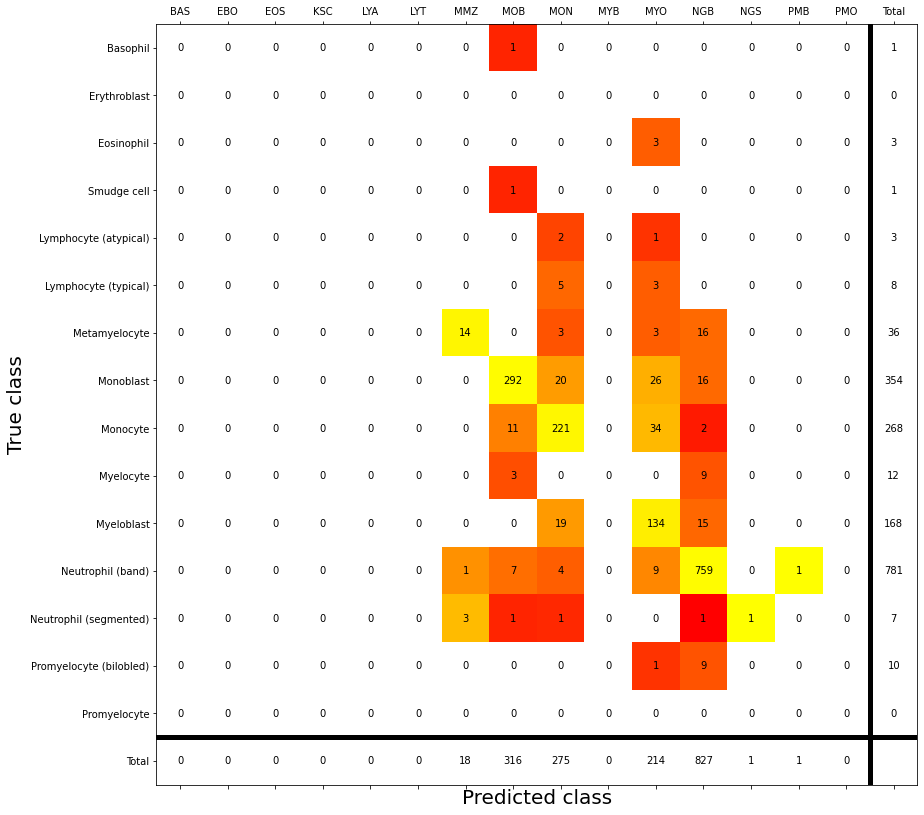

In [17]:
import matplotlib
from client.models.AMLmodel import classes as aml_classes

class_names_y = [aml_classes[k] for k in aml_classes] + ['Total']
class_names_x = [k for k in aml_classes] + ['Total']


def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.autumn):
    
    f, ax = plt.subplots(1,1,figsize=(20,14))
    color_mat = np.zeros(matrix.shape)
    color_mat[:15,:15] = matrix[:15,:15]/np.maximum(1,np.sum(matrix[:15,:15],0))
    ax.matshow(color_mat, cmap=cmap, norm=matplotlib.colors.LogNorm()) 

    tick_mark = np.arange(16)
    ax.set_xticks(tick_mark)
    ax.set_yticks(tick_mark)

    ax.set_xticklabels(class_names_x)
    ax.set_yticklabels(class_names_y)
    
    for (i, j), z in np.ndenumerate(matrix):
        
        if i+j < 30:
            
            ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center')

    ax.axvline(x=14.5,color='black',lw=5)
    ax.axhline(y=14.5,color='black', lw=5)
    ax.set_xlabel('Predicted class', fontsize=20)
    ax.set_ylabel('True class', fontsize=20)

M = confusion_matrix(model, train_gen)
plot_confusion_matrix(M)
plt.savefig('confusion_sample.png')